## Programmatic Data Cleaning:

1. Define in words
2. Code
3. Test

**Cleaning** your data is the third step in data wrangling. It is where you fix the quality and tidiness issues that you identified in the assess step. In this lesson, you'll clean all of the issues you identified using Python and pandas.

This lesson will be structured as follows:

* You'll get remotivated (if you aren't already) to clean the dataset for lessons 3 and 4: Phase II clinical trial data that compares the efficacy and safety of a new oral insulin to treat diabetes to injectable insulin
* You'll learn about the data cleaning process: defining, coding, and testing
* You'll address the missing data first (and learn why it is usually important to address these completeness issues first)
* You'll tackle the tidiness issues next (and learn why this is usually the next logical step)
* And finally, you'll clean up the quality issues

You will leverage the most common cleaning functions and methods in the pandas library to clean the nineteen quality issues and four tidiness issues identified in Lesson 3. 

## The Process

The very first thing to do before any cleaning occurs is to make a copy of each piece of data. All of the cleaning operations will be conducted on this copy so you can still view the original dirty and/or messy dataset later. Copying DataFrames in pandas is done using the `copy` method. If the original DataFrame was called `df`, the soon-to-be clean copy of the dataset could be named `df_clean`.

```python
df_clean = df.copy()
```

Note that simply assigning a DataFrame to a new variable name leaves the original DataFrame vulnerable to modifications, as explained in the answers to this Stack Overflow question: ["Why should I make a copy of a DataFrame in pandas?"](https://stackoverflow.com/questions/27673231/why-should-i-make-a-copy-of-a-data-frame-in-pandas)

In [221]:
import pandas as pd

In [433]:
# load the data
patients = pd.read_csv('../3_assesing_data/patients.csv')
treatments = pd.read_csv('../3_assesing_data/treatments.csv')
adverse_reactions = pd.read_csv('../3_assesing_data/adverse_reactions.csv')

## #1 Assessing the Data

#### Quality

1. `treatments` table: 
    - missing `hba1c_change`
    - 'u' next to the start dose and end dose in the auralin and novodra columns
    - Lowercase given names and surnames
    - Missing records (280 records instead of 350)
    - Erroneous datatype (`auralin` and `novodra` should be integers)
    - Innacurate `hba1c_change` maximum value is wrong calculated
    - Nulls represented as dashes (-) in auralin and novodra columns
    
2. `pacients` table: 
    - Erroneous datatype (`zip code` is a float not a string; `assigned-sex`, `state` more appropriate as categorical data type; `zip-code` string, `birthdate` date time)
    - `zip code` has four digits sometimes 
    - Tim Neudorf height is 27 in instead of 72 in
    - Full state names sometimes, abbreviations other times
    - The given_name for the patient with the patient_id 9
    - Missing demographic information (address - contact columns)
    - Multiple phone formats
    - Default John Doe data
    - Multiple records for Jake Jakobsen, Gersten, Taylor
    - kgs instead of lbs for Zaitseva weight
    
3. `adverse_reactions` table:
    - Lowercase given names and surnames
    
#### Tidiness

1. `treatments` table: 
    - auralin and novodra columns should be split into three variables: `treatment` (auralin or novodra), `start_dose` and `end_dose`

2. `pacients` table:
    - `contact` column should be split into phone and e-mail address 

3. `adverse_reactions` table:
    - `adverse_reaction` variable inside of `treatments table`
    
We should have only two tables 
1. `pacients`:
    - `patient_id`
    - `assigned_sex`
    - `given_name`
    - `surname`
    - `address`
    - `city`
    - `state`
    - `zip_code`
    - `country`
    - `contact`
    - `birthdate`
    - `weight
    - `height`
    - `bmi`

2. `treatments`: 
    - `patient_id`
    - `treatment`
    - `start_dose`
    - `end_dose`
    - `hba1c_start`
    - `hba1c_end`
    - `adverse_reaction`

### Clean

In [434]:
patients_clean = patients.copy()
treatments_clean = treatments.copy()
adverse_reactions_clean = adverse_reactions.copy()

### Missing Data

It's usually best to find missing data first if you can
1. Missing demographic information (address - contact columns): cannot get this information

#### `treatments`: Missing records (280 instead of 350)

##### Define

* Import the cut treatments into a DataFrame and concatenate it with the original treatments DataFrame.

Note: the missing `treatments` records are stored in a file named `treatments_cut.csv`, which you can see in this Jupyter Notebook's dashboard (click the **jupyter** logo in the top lefthand corner of this Notebook). Hint: [documentation page](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.concat.html) for the function used in the solution.*

#### Code

In [435]:
# load the missing data
treatments_cut = pd.read_csv('treatments_cut.csv')
treatments_cut.shape

(70, 7)

In [436]:
# check the columns
treatments_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 7 columns):
given_name      70 non-null object
surname         70 non-null object
auralin         70 non-null object
novodra         70 non-null object
hba1c_start     70 non-null float64
hba1c_end       70 non-null float64
hba1c_change    42 non-null float64
dtypes: float64(3), object(4)
memory usage: 3.9+ KB


In [437]:
# concatenate two dataframes
treatments_clean = pd.concat([treatments_clean, treatments_cut], ignore_index=True)

#### Test

In [438]:
# check the shape of the new table
treatments_clean.shape

(350, 7)

#### `treatments`: Missing HbA1c changes and Inaccurate HbA1c changes (leading 4s mistaken as 9s)
*Note: the "Inaccurate HbA1c changes (leading 4s mistaken as 9s)" observation, which is an accuracy issue and not a completeness issue, is included in this header because it is also fixed by the cleaning operation that fixes the missing "Missing HbA1c changes" observation. Multiple observations in one **Define, Code, and Test** header occurs multiple times in this notebook.*

##### Define

Calculate `hba1c_change` as `hba1c_start` minus `hba1c_end`.

In [439]:
treatments_clean.hba1c_change = (treatments.hba1c_start - treatments.hba1c_end)

##### Test

In [440]:
# test for hba1c_change nulls
sum(treatments_clean.hba1c_change.isnull())

70

In [441]:
# test for hba1c_change values greater than 0.9
treatments_clean[treatments_clean.loc[:,"hba1c_change"] >= 0.9].hba1c_change.count()

0

### Tidiness

#### Contact column in `patients` table contains two variables: phone number and email

##### Define
Make two variables from contact: `phone` and `email` and delete `contact` column.

Hint 1: use regular expressions with pandas' [`str.extract` method](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.extract.html). Here is an amazing [regex tutorial](https://regexone.com/). 

Hint 2: [various phone number regex patterns](https://stackoverflow.com/questions/16699007/regular-expression-to-match-standard-10-digit-phone-number). 

Hint 3: [email address regex pattern](http://emailregex.com/), which you might need to modify to distinguish the email from the phone number.*

##### Code

In [442]:
sum(patients_clean.contact.isnull())

12

There are 12 missing contact information

In [443]:
patients_clean[patients_clean.contact.isnull()]

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,contact,birthdate,weight,height,bmi
209,210,female,Lalita,Eldarkhanov,NaN,NaN,NaN,NaN,NaN,NaN,8/14/1950,143.4,62,26.2
219,220,male,Mỹ,Quynh,NaN,NaN,NaN,NaN,NaN,NaN,4/9/1978,237.8,69,35.1
230,231,female,Elisabeth,Knudsen,NaN,NaN,NaN,NaN,NaN,NaN,9/23/1976,165.9,63,29.4
234,235,female,Martina,Tománková,NaN,NaN,NaN,NaN,NaN,NaN,4/7/1936,199.5,65,33.2
242,243,male,John,O'Brian,NaN,NaN,NaN,NaN,NaN,NaN,2/25/1957,205.3,74,26.4
249,250,male,Benjamin,Mehler,NaN,NaN,NaN,NaN,NaN,NaN,10/30/1951,146.5,69,21.6
257,258,male,Jin,Kung,NaN,NaN,NaN,NaN,NaN,NaN,5/17/1995,231.7,69,34.2
264,265,female,Wafiyyah,Asfour,NaN,NaN,NaN,NaN,NaN,NaN,11/3/1989,158.6,63,28.1
269,270,female,Flavia,Fiorentino,NaN,NaN,NaN,NaN,NaN,NaN,10/9/1937,175.2,61,33.1
278,279,female,Generosa,Cabán,NaN,NaN,NaN,NaN,NaN,NaN,12/16/1962,124.3,69,18.4


In [444]:
patients_clean.contact.head(10)

0             951-719-9170ZoeWellish@superrito.com
1            PamelaSHill@cuvox.de+1 (217) 569-3204
2                 402-363-6804JaeMDebord@gustr.com
3       PhanBaLiem@jourrapide.com+1 (732) 636-8246
4                  334-515-7487TimNeudorf@cuvox.de
5         386-334-5237RafaelCardosoCosta@gustr.com
6                775-533-5933MaryBAdams@einrot.com
7             XiuxiuChang@einrot.com1 408 778 3236
8          816-265-9578DavidGustafsson@armyspy.com
9    SophieCabreraIbarra@teleworm.us1 718 795 9124
Name: contact, dtype: object

In [445]:
# emails
patients_clean.contact.str.extract(r'([A-Za-z]+[A-Za-z0-9\.+_-]+@[A-Za-z0-9]+\.[a-zA-Z]+)')[:10]

,0
0,ZoeWellish@superrito.com
1,PamelaSHill@cuvox.de
2,JaeMDebord@gustr.com
3,PhanBaLiem@jourrapide.com
4,TimNeudorf@cuvox.de
5,RafaelCardosoCosta@gustr.com
6,MaryBAdams@einrot.com
7,XiuxiuChang@einrot.com
8,DavidGustafsson@armyspy.com
9,SophieCabreraIbarra@teleworm.us


In [446]:
patients_clean.contact.str.extract(r'([1-9]\d{2}-\d{3}-\d{4})')[:13]

,0
0,951-719-9170
1,NaN
2,402-363-6804
3,NaN
4,334-515-7487
5,386-334-5237
6,775-533-5933
7,NaN
8,816-265-9578
9,NaN


In [447]:
patients_clean.contact.str.extract(r'(\+\d{1}\s\(\d{3}\)\s\d{3}-\d{4})')[:2]

,0
0,NaN
1,+1 (217) 569-3204


In [448]:
patients_clean.contact.str.extract(r'([1-9]\d{2}\s\d{3}\s\d{4})')[:12]

,0
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,408 778 3236
8,NaN
9,718 795 9124


In [449]:
patients_clean.contact.str.extract(r'(\+\d{1}\s\(\d{3}\)\s\d{3}-\d{4}|[1-9]\d{2}-\d{3}-\d{4}|[1-9]\d{2}\s\d{3}\s\d{4})')[:5]

,0
0,951-719-9170
1,+1 (217) 569-3204
2,402-363-6804
3,+1 (732) 636-8246
4,334-515-7487


In [450]:
patients_clean.contact[:5]

0          951-719-9170ZoeWellish@superrito.com
1         PamelaSHill@cuvox.de+1 (217) 569-3204
2              402-363-6804JaeMDebord@gustr.com
3    PhanBaLiem@jourrapide.com+1 (732) 636-8246
4               334-515-7487TimNeudorf@cuvox.de
Name: contact, dtype: object

In [451]:
patients_clean.contact.str.extract(r'(?P<phone>\+\d{1}\s\(\d{3}\)\s\d{3}-\d{4}|[1-9]\d{2}-\d{3}-\d{4}|[1-9]\d{2}\s\d{3}\s\d{4})', expand=True)[:5]

,phone
0,951-719-9170
1,+1 (217) 569-3204
2,402-363-6804
3,+1 (732) 636-8246
4,334-515-7487


In [452]:
patients_clean.contact.str.extract(r'(?P<email>[A-Za-z]+[A-Za-z0-9\.+_-]+@[A-Za-z0-9]+\.[a-zA-Z]+)', expand=True)[:5]

,email
0,ZoeWellish@superrito.com
1,PamelaSHill@cuvox.de
2,JaeMDebord@gustr.com
3,PhanBaLiem@jourrapide.com
4,TimNeudorf@cuvox.de


In [453]:
# make columns for phone and email
patients_clean['phone'] = patients_clean.contact.str.extract(r'(\d{10}|\+\d{1}\s\(\d{3}\)\s\d{3}-\d{4}|[1-9]\d{2}-\d{3}-\d{4}|[1-9]\d{2}\s\d{3}\s\d{4})', expand=True)
patients_clean['email'] = patients_clean.contact.str.extract(r'([A-Za-z]+[A-Za-z0-9\.+_-]+@[A-Za-z0-9]+\.[a-zA-Z]+)', expand=True)

In [454]:
# lowercase email
patients_clean['email'] = patients_clean['email'].str.lower() 

In [455]:
# drop contact column
patients_clean.drop('contact', axis=1, inplace=True)

#### Test

In [456]:
# Confirm contact column is gone
list(patients_clean)

['patient_id',
 'assigned_sex',
 'given_name',
 'surname',
 'address',
 'city',
 'state',
 'zip_code',
 'country',
 'birthdate',
 'weight',
 'height',
 'bmi',
 'phone',
 'email']

In [457]:
# take a look at the new table
patients_clean.head()

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone,email
0,1,female,Zoe,Wellish,576 Brown Bear Drive,Rancho California,California,92390.0,United States,7/10/1976,121.7,66,19.6,951-719-9170,zoewellish@superrito.com
1,2,female,Pamela,Hill,2370 University Hill Road,Armstrong,Illinois,61812.0,United States,4/3/1967,118.8,66,19.2,+1 (217) 569-3204,pamelashill@cuvox.de
2,3,male,Jae,Debord,1493 Poling Farm Road,York,Nebraska,68467.0,United States,2/19/1980,177.8,71,24.8,402-363-6804,jaemdebord@gustr.com
3,4,male,Liêm,Phan,2335 Webster Street,Woodbridge,NJ,7095.0,United States,7/26/1951,220.9,70,31.7,+1 (732) 636-8246,phanbaliem@jourrapide.com
4,5,male,Tim,Neudorf,1428 Turkey Pen Lane,Dothan,AL,36303.0,United States,2/18/1928,192.3,27,26.1,334-515-7487,timneudorf@cuvox.de


In [458]:
len(patients_clean[patients_clean.phone.isnull()])

12

#### Three variables in two columns in `treatments` table (treatment, start dose and end dose)

##### Define
*Your definition here. Hint: use pandas' [melt function](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.melt.html) and [`str.split()` method](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.split.html). Here is an excellent [`melt` tutorial](https://deparkes.co.uk/2016/10/28/reshape-pandas-data-with-melt/).*

In [459]:
treatments_clean.head()

,given_name,surname,auralin,novodra,hba1c_start,hba1c_end,hba1c_change
0,veronika,jindrová,41u - 48u,-,7.63,7.20,0.43
1,elliot,richardson,-,40u - 45u,7.56,7.09,0.47
2,yukitaka,takenaka,-,39u - 36u,7.68,7.25,0.43
3,skye,gormanston,33u - 36u,-,7.97,7.62,0.35
4,alissa,montez,-,33u - 29u,7.78,7.46,0.32


In [460]:
# melt the auralin and novodra columns
treatments_clean = pd.melt(treatments_clean, id_vars=['given_name', "surname", "hba1c_start", "hba1c_end", "hba1c_change"],
                 var_name="treatment", value_name="dose")

In [461]:
treatments_clean.head()

,given_name,surname,hba1c_start,hba1c_end,hba1c_change,treatment,dose
0,veronika,jindrová,7.63,7.20,0.43,auralin,41u - 48u
1,elliot,richardson,7.56,7.09,0.47,auralin,-
2,yukitaka,takenaka,7.68,7.25,0.43,auralin,-
3,skye,gormanston,7.97,7.62,0.35,auralin,33u - 36u
4,alissa,montez,7.78,7.46,0.32,auralin,-


In [462]:
# remove - values from dataframe and reindex
treatments_clean = treatments_clean[treatments_clean.dose != '-'].reset_index(drop=True)

In [463]:
treatments_clean['dose'].str.split(' - ', 1).str

In [464]:
# create the columns
treatments_clean['dose_start'], treatments_clean['dose_end'] = treatments_clean['dose'].str.split(' - ', 1).str
# drop the dose column
treatments_clean = treatments_clean.drop('dose', axis=1)

##### Test

In [465]:
# check the shape
treatments_clean.shape

(350, 8)

In [466]:
# assess head
treatments_clean.head()

,given_name,surname,hba1c_start,hba1c_end,hba1c_change,treatment,dose_start,dose_end
0,veronika,jindrová,7.63,7.20,0.43,auralin,41u,48u
1,skye,gormanston,7.97,7.62,0.35,auralin,33u,36u
2,sophia,haugen,7.65,7.27,0.38,auralin,37u,42u
3,eddie,archer,7.89,7.55,0.34,auralin,31u,38u
4,asia,woźniak,7.76,7.37,0.39,auralin,30u,36u


In [467]:
# assess tail
treatments_clean.tail()

,given_name,surname,hba1c_start,hba1c_end,hba1c_change,treatment,dose_start,dose_end
345,christopher,woodward,7.51,7.06,NaN,novodra,55u,51u
346,maret,sultygov,7.67,7.30,NaN,novodra,26u,23u
347,lixue,hsueh,9.21,8.80,NaN,novodra,22u,23u
348,jakob,jakobsen,7.96,7.51,NaN,novodra,28u,26u
349,berta,napolitani,7.68,7.21,NaN,novodra,42u,44u


In [468]:
# check for data types
treatments_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 8 columns):
given_name      350 non-null object
surname         350 non-null object
hba1c_start     350 non-null float64
hba1c_end       350 non-null float64
hba1c_change    280 non-null float64
treatment       350 non-null object
dose_start      350 non-null object
dose_end        350 non-null object
dtypes: float64(3), object(5)
memory usage: 22.0+ KB


#### Adverse reaction should be part of the `treatments` table

##### Define
*Your definition here. Hint: [tutorial](https://chrisalbon.com/python/pandas_join_merge_dataframe.html) for the function used in the solution.*

##### Code

In [469]:
adverse_reactions_clean

,given_name,surname,adverse_reaction
0,berta,napolitani,injection site discomfort
1,lena,baer,hypoglycemia
2,joseph,day,hypoglycemia
3,flavia,fiorentino,cough
4,manouck,wubbels,throat irritation
5,jasmine,sykes,hypoglycemia
6,louise,johnson,hypoglycemia
7,albinca,komavec,hypoglycemia
8,noe,aranda,hypoglycemia
9,sofia,hermansen,injection site discomfort


In [470]:
# merge the dataframes
treatments_clean = pd.merge(treatments_clean, adverse_reactions_clean, how='left')

In [471]:
treatments_clean

,given_name,surname,hba1c_start,hba1c_end,hba1c_change,treatment,dose_start,dose_end,adverse_reaction
0,veronika,jindrová,7.63,7.20,0.43,auralin,41u,48u,NaN
1,skye,gormanston,7.97,7.62,0.35,auralin,33u,36u,NaN
2,sophia,haugen,7.65,7.27,0.38,auralin,37u,42u,NaN
3,eddie,archer,7.89,7.55,0.34,auralin,31u,38u,NaN
4,asia,woźniak,7.76,7.37,0.39,auralin,30u,36u,NaN
5,joseph,day,7.70,7.19,0.51,auralin,29u,36u,hypoglycemia
6,roxanne,andreyeva,9.54,9.14,0.40,auralin,29u,38u,NaN
7,simone,baumgaertner,7.74,7.30,0.44,auralin,27u,37u,NaN
8,enco,žibrik,7.78,7.34,0.44,auralin,55u,68u,NaN
9,camilla,zaitseva,7.53,7.13,0.40,auralin,28u,37u,NaN


##### Test

In [472]:
treatments_clean[treatments_clean.adverse_reaction.notnull()].head()

,given_name,surname,hba1c_start,hba1c_end,hba1c_change,treatment,dose_start,dose_end,adverse_reaction
5,joseph,day,7.70,7.19,0.51,auralin,29u,36u,hypoglycemia
13,clinton,miller,7.79,7.40,0.39,auralin,42u,51u,throat irritation
33,louise,johnson,7.63,7.32,0.31,auralin,32u,42u,hypoglycemia
42,finley,chandler,7.65,7.26,0.39,auralin,31u,45u,headache
46,idalia,moore,8.34,7.90,0.44,auralin,25u,31u,hypoglycemia


#### Given name and surname columns in `patients` table duplicated in `treatments` and `adverse_reactions` tables  and Lowercase given names and surnames

##### Define
Use the `drop_duplicates` function to drop duplicates from the `treatment_clean` table.  

Hint: [tutorial](https://chrisalbon.com/python/pandas_join_merge_dataframe.html) for one function used in the solution and [tutorial](http://erikrood.com/Python_References/dropping_rows_cols_pandas.html) for another function used in the solution.*

In [473]:
treatments_clean[treatments_clean.given_name.duplicated()]

,given_name,surname,hba1c_start,hba1c_end,hba1c_change,treatment,dose_start,dose_end,adverse_reaction
62,joseph,day,7.70,7.19,0.51,auralin,29u,36u,hypoglycemia
106,alexander,hueber,7.71,7.35,0.36,auralin,35u,38u,NaN
128,rebecca,jephcott,7.96,7.57,0.39,auralin,53u,63u,NaN
167,joseph,tucker,7.67,7.30,NaN,auralin,48u,56u,NaN
168,robert,maslov,7.65,7.35,NaN,auralin,55u,68u,NaN
244,david,gustafsson,7.72,7.28,0.44,novodra,33u,34u,NaN
246,søren,sørensen,7.93,7.59,0.34,novodra,41u,39u,NaN
254,mustafa,lindström,7.92,7.60,0.32,novodra,35u,33u,NaN
293,anja,hueber,8.82,8.36,0.46,novodra,31u,32u,NaN
308,david,beauvais,7.87,7.47,0.40,novodra,26u,23u,NaN


In [474]:
# drop duplicates
treatments_clean['given_name'].drop_duplicates(inplace=True)
# drop the columns
treatments_clean = treatments_clean.drop(['given_name', 'surname'], axis=1)

In [475]:
# lowercase given name and surname columns
patients_clean['given_name'] = patients_clean.given_name.str.lower()
patients_clean['surname'] = patients_clean.surname.str.lower()

##### Test

In [476]:
# check a sample of 5 for lowercase names
patients_clean.head()

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone,email
0,1,female,zoe,wellish,576 Brown Bear Drive,Rancho California,California,92390.0,United States,7/10/1976,121.7,66,19.6,951-719-9170,zoewellish@superrito.com
1,2,female,pamela,hill,2370 University Hill Road,Armstrong,Illinois,61812.0,United States,4/3/1967,118.8,66,19.2,+1 (217) 569-3204,pamelashill@cuvox.de
2,3,male,jae,debord,1493 Poling Farm Road,York,Nebraska,68467.0,United States,2/19/1980,177.8,71,24.8,402-363-6804,jaemdebord@gustr.com
3,4,male,liêm,phan,2335 Webster Street,Woodbridge,NJ,7095.0,United States,7/26/1951,220.9,70,31.7,+1 (732) 636-8246,phanbaliem@jourrapide.com
4,5,male,tim,neudorf,1428 Turkey Pen Lane,Dothan,AL,36303.0,United States,2/18/1928,192.3,27,26.1,334-515-7487,timneudorf@cuvox.de


In [477]:
treatments_clean.head()

,hba1c_start,hba1c_end,hba1c_change,treatment,dose_start,dose_end,adverse_reaction
0,7.63,7.20,0.43,auralin,41u,48u,NaN
1,7.97,7.62,0.35,auralin,33u,36u,NaN
2,7.65,7.27,0.38,auralin,37u,42u,NaN
3,7.89,7.55,0.34,auralin,31u,38u,NaN
4,7.76,7.37,0.39,auralin,30u,36u,NaN


### Quality

#### Zip code is a float not a string and Zip code has four digits sometimes

##### Define
Convert the zip code column's data type from a float to a string using `astype`, remove the '.0' using string slicing, and pad four digit zip codes with a leading 0. 

Hint: see the "Data Cleaning Process" page.*

##### Code

In [478]:
# create a list with new codes
new_codes = ["0" + code[0] if (len(code[0]) == 4) else code[0] for code in patients_clean.zip_code.astype('str').str.split(".")]

In [479]:
# assign the new codes
patients_clean["zip_code"] = new_codes

In [480]:
import numpy as np 

# Reconvert NaNs entries that were converted to '0000n' by code above
patients_clean.zip_code = patients_clean.zip_code.replace('0000n', np.nan)

##### Test

In [481]:
patients_clean.zip_code.head()

0    92390
1    61812
2    68467
3    07095
4    36303
Name: zip_code, dtype: object

#### Tim Neudorf height is 27 in instead of 72 in

##### Define

Replace height for rows in the `patients` table that have a height of 27 in (there is only one) with 72 in.

##### Code

In [482]:
# see the entry
patients_clean[patients_clean['surname'] == "neudorf"]

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone,email
4,5,male,tim,neudorf,1428 Turkey Pen Lane,Dothan,AL,36303,United States,2/18/1928,192.3,27,26.1,334-515-7487,timneudorf@cuvox.de


In [483]:
# change the value of the value for the row nr 4 and column height
patients_clean.loc[4, 'height'] = 72

##### Test

In [484]:
# check to see if change has been made
patients_clean.iloc[[4]]['height'] == 72

4    True
Name: height, dtype: bool

#### Full state names sometimes, abbreviations other times

##### Define
Make a function to change the state's names and apply it to the `state` column.

Hint: [tutorial](https://chrisalbon.com/python/pandas_apply_operations_to_dataframes.html) for method used in solution.*

In [485]:
# check each value in the table
patients_clean.state.value_counts()

California    36
TX            32
New York      25
CA            24
MA            22
NY            22
PA            18
GA            15
OH            14
Illinois      14
OK            13
Florida       13
LA            13
MI            13
NJ            12
VA            11
WI            10
IL            10
MS            10
AL             9
IN             9
TN             9
MN             9
FL             9
KY             8
WA             8
NC             8
MO             7
NV             6
KS             6
ID             6
SC             5
IA             5
CT             5
AR             4
CO             4
Nebraska       4
ME             4
RI             4
ND             4
AZ             4
DE             3
OR             3
SD             3
WV             3
MD             3
DC             2
NE             2
VT             2
MT             2
WY             1
AK             1
NM             1
NH             1
Name: state, dtype: int64

In [486]:
# a function that changes the names of the Full state names into abbreviations
def states(x):
    if x == "California":
        x = "CA"
    elif x == "New York":
        x = "NY"
    elif x == "Illinois":
        x = "IL"
    elif x == "Nebraska":
        x = "NE"
    elif x == "Florida":
        x = "FL"
    return x

In [487]:
# apply the function and assign the new values
patients_clean['state'] = patients_clean['state'].apply(states)

##### Test

In [488]:
# check the changes
patients_clean.state.value_counts()

CA    60
NY    47
TX    32
IL    24
FL    22
MA    22
PA    18
GA    15
OH    14
MI    13
LA    13
OK    13
NJ    12
VA    11
MS    10
WI    10
MN     9
AL     9
TN     9
IN     9
NC     8
WA     8
KY     8
MO     7
ID     6
NE     6
NV     6
KS     6
CT     5
SC     5
IA     5
ME     4
AR     4
RI     4
CO     4
ND     4
AZ     4
SD     3
DE     3
WV     3
MD     3
OR     3
VT     2
MT     2
DC     2
NH     1
WY     1
AK     1
NM     1
Name: state, dtype: int64

#### Dsvid Gustafsson

##### Define
Identify the observation and manually make the change.

##### Code

In [489]:
# identify the observation in the patient_clean table
patients_clean[patients_clean['surname'] == "gustafsson"]

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone,email
8,9,male,dsvid,gustafsson,1790 Nutter Street,Kansas City,MO,64105,United States,3/6/1937,163.9,66,26.5,816-265-9578,davidgustafsson@armyspy.com


In [490]:
# change the value of the value for the row nr 8 and column given_name
#patients_clean.loc[8, 'given_name'] = 'david'

In [491]:
# alternate code
patients_clean.given_name = patients_clean.given_name.replace('dsvid', 'david')

##### Test

In [492]:
# check to see if the change has been made
patients_clean.loc[8, 'given_name'] == 'david'

True

#### Erroneous datatypes (assigned sex, state, zip_code, and birthdate columns) and Erroneous datatypes (auralin and novodra columns) and The letter 'u' in starting and ending doses for Auralin and Novodra

##### Define
*Your definition here. Hint: [documentation page](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.astype.html) for one method used in solution, [documentation page](http://pandas.pydata.org/pandas-docs/version/0.20/generated/pandas.to_datetime.html) for one function used in the solution, and [documentation page](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.strip.html) for another method used in the solution.*

In [493]:
# variable types
patients_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 15 columns):
patient_id      503 non-null int64
assigned_sex    503 non-null object
given_name      503 non-null object
surname         503 non-null object
address         491 non-null object
city            491 non-null object
state           491 non-null object
zip_code        503 non-null object
country         491 non-null object
birthdate       503 non-null object
weight          503 non-null float64
height          503 non-null int64
bmi             503 non-null float64
phone           491 non-null object
email           491 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 59.0+ KB


In [494]:
# check to see the values in the column
patients_clean.assigned_sex.value_counts()

male      253
female    250
Name: assigned_sex, dtype: int64

In [495]:
# change the assigned_sex data type to category
patients_clean.assigned_sex = patients_clean.assigned_sex.astype('category')

In [496]:
# change the state data type to category
patients_clean.state = patients_clean.state.astype('category')

In [497]:
# change the zip_code data type to category
patients_clean.zip_code = patients_clean.zip_code.astype('category')

In [498]:
# change the birthdate data type to datetime
patients_clean.birthdate = pd.to_datetime(patients_clean['birthdate'])

In [499]:
# Strip u and to integer
treatments_clean.dose_start = treatments_clean.dose_start.str.strip('u').astype(int)
treatments_clean.dose_end = treatments_clean.dose_end.str.strip('u').astype(int)

##### Test

In [500]:
patients_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 15 columns):
patient_id      503 non-null int64
assigned_sex    503 non-null category
given_name      503 non-null object
surname         503 non-null object
address         491 non-null object
city            491 non-null object
state           491 non-null category
zip_code        503 non-null category
country         491 non-null object
birthdate       503 non-null datetime64[ns]
weight          503 non-null float64
height          503 non-null int64
bmi             503 non-null float64
phone           491 non-null object
email           491 non-null object
dtypes: category(3), datetime64[ns](1), float64(2), int64(2), object(7)
memory usage: 74.3+ KB


In [501]:
treatments_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350 entries, 0 to 349
Data columns (total 7 columns):
hba1c_start         350 non-null float64
hba1c_end           350 non-null float64
hba1c_change        280 non-null float64
treatment           350 non-null object
dose_start          350 non-null int32
dose_end            350 non-null int32
adverse_reaction    35 non-null object
dtypes: float64(3), int32(2), object(2)
memory usage: 19.1+ KB


#### Multiple phone number formats

##### Define the string.

Hint: helpful [Stack Overflow answer](https://stackoverflow.com/a/123681).

##### Code

In [502]:
# returns only the digits from a string
def phone_nr(x):
    return ''.join(i for i in str(x) if i.isdigit())

In [503]:
# apply the function and assign the new values to the phone column
patients_clean['phone'] = patients_clean['phone'].apply(phone_nr)

In [504]:
 patients_clean.phone = patients_clean.phone.str.pad(11, fillchar='1')

##### Test

In [505]:
# check for changes
patients_clean['phone'].head()

0    19517199170
1    12175693204
2    14023636804
3    17326368246
4    13345157487
Name: phone, dtype: object

#### Default John Doe data

##### Define
Remove the non-recoverable John Doe records from the `patients` table.
Recall that it is assumed that the data that this John Doe data displaced is not recoverable.

##### Code

In [506]:
patients_clean.shape, treatments_clean.shape

((503, 15), (350, 7))

In [507]:
# check the John Doe data
patients_clean[patients_clean['surname'] == 'doe']

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone,email
215,216,male,john,doe,123 Main Street,New York,NY,12345,United States,1975-01-01,180.0,72,24.4,11234567890,johndoe@email.com
229,230,male,john,doe,123 Main Street,New York,NY,12345,United States,1975-01-01,180.0,72,24.4,11234567890,johndoe@email.com
237,238,male,john,doe,123 Main Street,New York,NY,12345,United States,1975-01-01,180.0,72,24.4,11234567890,johndoe@email.com
244,245,male,john,doe,123 Main Street,New York,NY,12345,United States,1975-01-01,180.0,72,24.4,11234567890,johndoe@email.com
251,252,male,john,doe,123 Main Street,New York,NY,12345,United States,1975-01-01,180.0,72,24.4,11234567890,johndoe@email.com
277,278,male,john,doe,123 Main Street,New York,NY,12345,United States,1975-01-01,180.0,72,24.4,11234567890,johndoe@email.com


In [508]:
# remove the default data
patients_clean = patients_clean[patients_clean['surname'] != 'doe']

##### Test

In [509]:
# check to see if there are any default records in the dataframe
patients_clean[patients_clean['surname'] == 'doe'].shape[0], patients_clean.shape

(0, (497, 15))

#### Multiple records for Jakobsen, Gersten, Taylor

##### Define

Remove the Jake Jakobsen, Pat Gersten, and Sandy Taylor rows from the `patients` table. These are the nicknames, which happen to also not be in the `treatments` table (removing the wrong name would create a consistency issue between the `patients` and `treatments` table). These are all the second occurrence of the duplicate. These are also the only occurences of non-null duplicate addresses.

In [510]:
# tilde means not: http://pandas.pydata.org/pandas-docs/stable/indexing.html#boolean-indexing
patients_clean = patients_clean[~((patients_clean.address.duplicated()) & patients_clean.address.notnull())]

##### Test

In [511]:
# query the dataframe to see the records
patients_clean.query("surname == 'jakobsen' or surname == 'gersten' or surname =='taylor'")

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone,email
24,25,male,jakob,jakobsen,648 Old Dear Lane,Port Jervis,NY,12771,United States,1985-08-01,155.8,67,24.4,18458587707,jakobcjakobsen@einrot.com
97,98,male,patrick,gersten,2778 North Avenue,Burr,NE,68324,United States,1954-05-03,138.2,71,19.3,14028484923,patrickgersten@rhyta.com
131,132,female,sandra,taylor,2476 Fulton Street,Rainelle,WV,25962,United States,1960-10-23,206.1,64,35.4,13044382648,sandractaylor@dayrep.com
426,427,male,rogelio,taylor,4064 Marigold Lane,Miami,FL,33179,United States,1992-09-02,186.6,69,27.6,13054346299,rogeliojtaylor@teleworm.us
432,433,female,karen,jakobsen,1690 Fannie Street,Houston,TX,77020,United States,1962-11-25,185.2,67,29.0,19792030438,karenjakobsen@jourrapide.com


In [512]:
patients_clean.shape

(494, 15)

#### kgs instead of lbs for Zaitseva weight

##### Define

Transform weight from kgs to lbs.

##### Code

In [513]:
# reset index
patients_clean = patients_clean.reset_index(drop=True)

In [514]:
# check the record
patients_clean[patients_clean.surname == 'zaitseva']

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone,email
209,211,female,camilla,zaitseva,4689 Briarhill Lane,Wooster,OH,44691,United States,1938-11-26,48.8,63,19.1,13302022145,camillazaitseva@superrito.com


In [515]:
weight_kg = patients_clean.weight.min()
mask = patients_clean.surname == 'zaitseva'
column_name = 'weight'
patients_clean.loc[mask, column_name] = weight_kg * 2.20462

##### Test

In [516]:
# check the record
patients_clean[patients_clean.surname == 'zaitseva']

,patient_id,assigned_sex,given_name,surname,address,city,state,zip_code,country,birthdate,weight,height,bmi,phone,email
209,211,female,camilla,zaitseva,4689 Briarhill Lane,Wooster,OH,44691,United States,1938-11-26,107.585456,63,19.1,13302022145,camillazaitseva@superrito.com


## Auralin vs. Novodra: Clinical Trial Key Metrics

### Adverse Reactions

In [517]:
after_adverse_reactions = treatments_clean.groupby(['treatment', 'adverse_reaction'])['hba1c_start'].count()
after_adverse_reactions

treatment  adverse_reaction         
auralin    cough                         1
           headache                      1
           hypoglycemia                 10
           nausea                        1
           throat irritation             2
novodra    cough                         1
           headache                      2
           hypoglycemia                 10
           injection site discomfort     6
           nausea                        1
Name: hba1c_start, dtype: int64

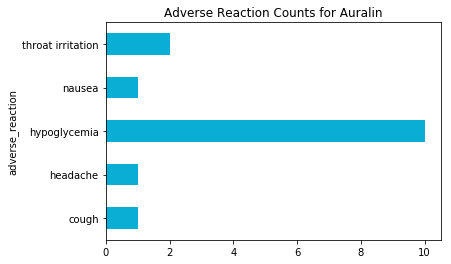

In [519]:
after_adverse_reactions.auralin.plot(kind='barh',
                                     title='Adverse Reaction Counts for Auralin',
                                     color='#09aed5');

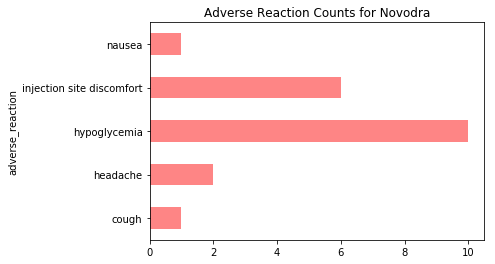

In [520]:
after_adverse_reactions.novodra.plot(kind='barh',
                                     title='Adverse Reaction Counts for Novodra',
                                     color='#fe8585');

## Pre-trial/Post-trial Mean Insulin Dose Change (IU)

*Note: insulin is measured in international units of insulin (e.g. 1IU or 1u).

In [521]:
after_mean = treatments_clean.groupby(['treatment'])['dose_start'].mean() - treatments_clean.groupby(['treatment'])['dose_end'].mean()
after_mean

treatment
auralin   -8.325714
novodra    0.377143
dtype: float64

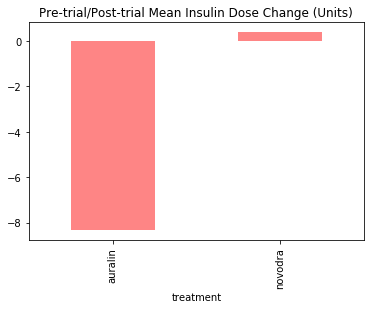

In [522]:
after_mean.plot(kind='bar',
                title='Pre-trial/Post-trial Mean Insulin Dose Change (Units)',
                color='#fe8585')

This means that patients that were treated with Auralin required on average, 8 more units of insulin to establish a safe steady blood sugar level. That's compared to Novodra who on average required 0.4 units less of insulin.

## Hba1c 

Hba1c change is our key indicator for diabetes control. Most of the patients are starting around 7.9%. Measure the effectiveness through a confidence interval.

#### Difference in means of Hba1c changes between Auralin and Novodra

In [523]:
treatments_clean.groupby(['treatment'])['hba1c_change'].mean()

treatment
auralin    0.385985
novodra    0.406853
Name: hba1c_change, dtype: float64

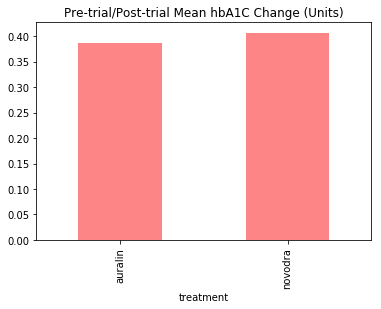

In [524]:
treatments_clean.groupby(['treatment'])['hba1c_change'].mean().plot(kind='bar',
                title='Pre-trial/Post-trial Mean hbA1C Change (Units)',
                color='#fe8585');

In [536]:
import statsmodels.stats.api as sms

### Confidence Interval for Difference in Hba1c Chabge (Novodra - Auralin)

A "noninferior" difference between the two groups was predetermined as the upper limit of the confidence interval to be less than 0.4%.

In [554]:
treatments_clean['hba1c_change'] = treatments_clean['hba1c_start'] - treatments_clean['hba1c_end'] 

In [557]:
X1 = treatments_clean[treatments_clean['treatment'] == "auralin"]['hba1c_change']
X2 = treatments_clean[treatments_clean['treatment'] == "novodra"]['hba1c_change']

cm = sms.CompareMeans(sms.DescrStatsW(X2), sms.DescrStatsW(X1))
cm.tconfint_diff(usevar='unequal')

(0.0049075695784076955, 0.029606716135878244)

The upper limit of 0.03 roughly is less than 0.4. Oral insulin is similarly effective to injectable insulin according to this clinical trial. This means that Auralin passed to Phase II clinical trials.